In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [3]:
from __future__ import print_function, division

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [4]:
data_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data') 

In [5]:
labels = os.listdir(data_dir)

# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training (100'000 items)
files_data = []
labels_data = []
for label in labels:
    for filename in os.listdir(data_dir + '/' + label ):
        files_data.append(data_dir + '/' + label + '/' + filename)
        labels_data.append(label)

In [36]:
labels

['Non_violation', 'Violation']

In [6]:
print("The first five files from the list of train images:", files_data[:5])
print("\nThe first five labels from the list of train labels:", labels_data[:5])

The first five files from the list of train images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_2_2994144.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/Copy of _6_5523581.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_0_5482144.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_4_27430.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_11_1737337.jpg']

The first five labels from the list of train labels: ['Non_violation', 'Non_violation', 'Non_violation', 'Non_violation', 'Non_violation']


In [7]:
print(len(labels_data))

1289


In [228]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = self.transforms(pic)
            return x, self.files[index]

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])

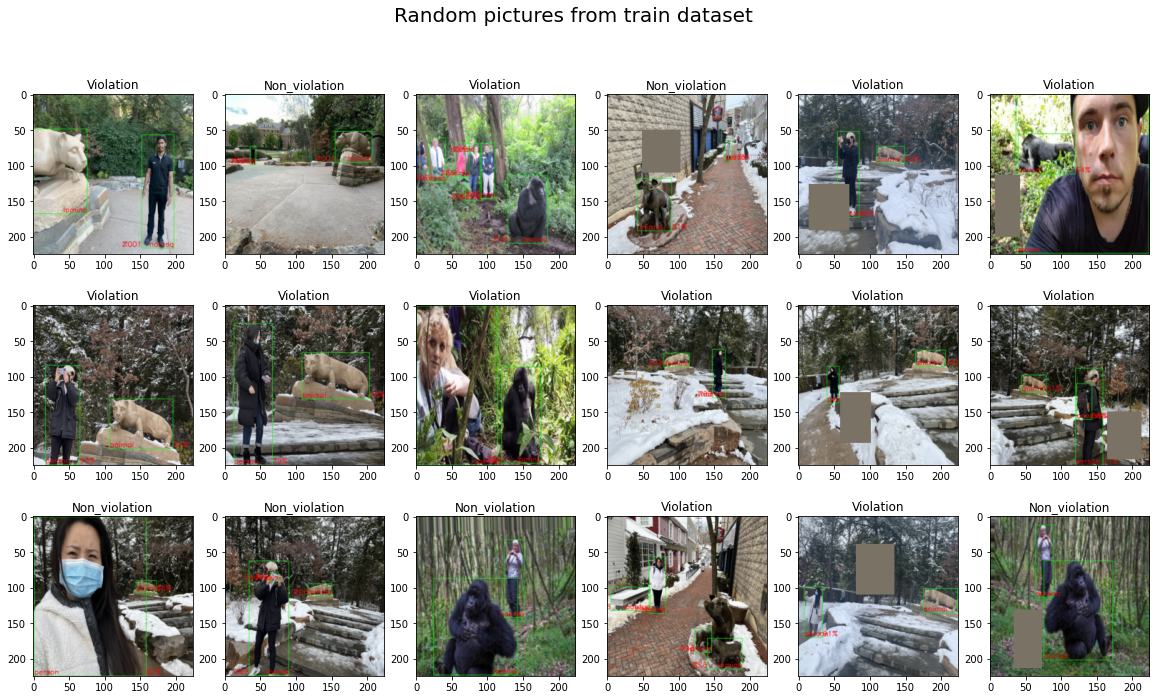

In [9]:

dataset = ImagesDataset(files=files_data,
                              labels=labels_data,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')



fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(dataset))
    img = dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([dataset[n][1]])[0])
    ax.imshow(img)

In [206]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [900, 289, 100])

In [207]:
print(len(train_dataset),len(val_dataset), len(test_dataset))

900 289 100


In [208]:
labels_test = []
for i in range(len(test_dataset)):
  labels_test.append(encoder_labels.inverse_transform([test_dataset[i][1]])[0])

In [209]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

In [17]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):
    since = time.time()

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_last_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array
    
    
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=False)
num_epochs = 25

In [19]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  4%|▍         | 1/25 [00:46<18:38, 46.60s/it]

	| New lowest val loss for DenseNet161: 0.019970372138757606
Epoch: 2 | Learning rate: [0.007]


  8%|▊         | 2/25 [01:33<17:53, 46.68s/it]

	| New lowest val loss for DenseNet161: 0.010811378463948062
Epoch: 3 | Learning rate: [0.007]


 12%|█▏        | 3/25 [02:19<17:05, 46.61s/it]

	| New lowest val loss for DenseNet161: 0.008696679193462054
Epoch: 4 | Learning rate: [0.00231]


 16%|█▌        | 4/25 [03:06<16:17, 46.54s/it]

Epoch: 5 | Learning rate: [0.00231]


 20%|██        | 5/25 [03:52<15:26, 46.30s/it]

Epoch: 6 | Learning rate: [0.00231]


 24%|██▍       | 6/25 [04:38<14:42, 46.45s/it]

	| New lowest val loss for DenseNet161: 0.008361963046050814
Epoch: 7 | Learning rate: [0.0007623]


 28%|██▊       | 7/25 [05:25<13:56, 46.49s/it]

Epoch: 8 | Learning rate: [0.0007623]


 32%|███▏      | 8/25 [06:11<13:07, 46.34s/it]

Epoch: 9 | Learning rate: [0.0007623]


 36%|███▌      | 9/25 [06:58<12:25, 46.62s/it]

	| New lowest val loss for DenseNet161: 0.00778997911198329
Epoch: 10 | Learning rate: [0.00025155900000000005]


 40%|████      | 10/25 [07:45<11:39, 46.66s/it]

Epoch: 11 | Learning rate: [0.00025155900000000005]


 44%|████▍     | 11/25 [08:32<10:56, 46.87s/it]

	| New lowest val loss for DenseNet161: 0.007550546171137206
Epoch: 12 | Learning rate: [0.00025155900000000005]


 48%|████▊     | 12/25 [09:19<10:07, 46.75s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 52%|█████▏    | 13/25 [10:06<09:21, 46.83s/it]

	| New lowest val loss for DenseNet161: 0.007426578951129452
Epoch: 14 | Learning rate: [8.301447000000002e-05]


 56%|█████▌    | 14/25 [10:53<08:35, 46.85s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 60%|██████    | 15/25 [11:40<07:48, 46.85s/it]

	| New lowest val loss for DenseNet161: 0.006912841696846444
Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 64%|██████▍   | 16/25 [12:26<07:01, 46.87s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 68%|██████▊   | 17/25 [13:13<06:14, 46.84s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 72%|███████▏  | 18/25 [14:00<05:28, 46.96s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 76%|███████▌  | 19/25 [14:46<04:39, 46.57s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 80%|████████  | 20/25 [15:32<03:52, 46.45s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 84%|████████▍ | 21/25 [16:19<03:06, 46.58s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 88%|████████▊ | 22/25 [17:05<02:18, 46.32s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 92%|█████████▏| 23/25 [17:51<01:32, 46.39s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 96%|█████████▌| 24/25 [18:38<00:46, 46.55s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


100%|██████████| 25/25 [19:26<00:00, 46.64s/it]


Training complete in 19m 26s


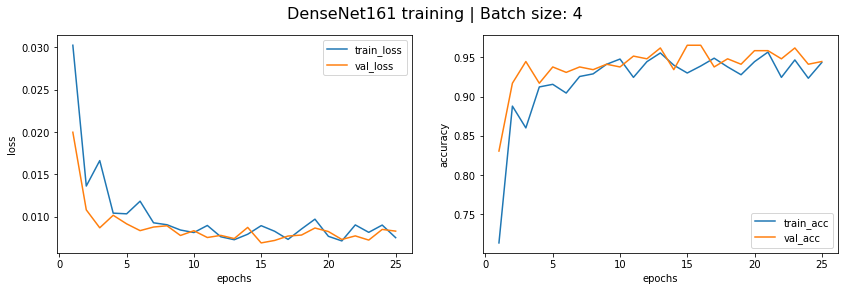


Training results:
	Min val loss 0.0069 was achieved during epoch #15
	Val accuracy during min val loss is 0.9654


In [20]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=2)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=val_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  4%|▍         | 1/25 [00:42<16:49, 42.05s/it]

	| New lowest val loss for ResNet50: 0.01829611850341711
Epoch: 2 | Learning rate: [0.007]


  8%|▊         | 2/25 [01:24<16:17, 42.51s/it]

	| New lowest val loss for ResNet50: 0.01792479102793037
Epoch: 3 | Learning rate: [0.007]


 12%|█▏        | 3/25 [02:07<15:36, 42.56s/it]

	| New lowest val loss for ResNet50: 0.01546987385898313
Epoch: 4 | Learning rate: [0.00231]


 16%|█▌        | 4/25 [02:50<14:57, 42.74s/it]

Epoch: 5 | Learning rate: [0.00231]


 20%|██        | 5/25 [03:33<14:15, 42.75s/it]

Epoch: 6 | Learning rate: [0.00231]


 24%|██▍       | 6/25 [04:17<13:39, 43.12s/it]

	| New lowest val loss for ResNet50: 0.014548429490991941
Epoch: 7 | Learning rate: [0.0007623]


 28%|██▊       | 7/25 [05:01<13:02, 43.45s/it]

Epoch: 8 | Learning rate: [0.0007623]


 32%|███▏      | 8/25 [05:44<12:16, 43.35s/it]

	| New lowest val loss for ResNet50: 0.012367621489565266
Epoch: 9 | Learning rate: [0.0007623]


 36%|███▌      | 9/25 [06:26<11:28, 43.02s/it]

Epoch: 10 | Learning rate: [0.00025155900000000005]


 40%|████      | 10/25 [07:08<10:40, 42.70s/it]

	| New lowest val loss for ResNet50: 0.01234585972290138
Epoch: 11 | Learning rate: [0.00025155900000000005]


 44%|████▍     | 11/25 [07:50<09:52, 42.31s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 48%|████▊     | 12/25 [08:32<09:10, 42.31s/it]

	| New lowest val loss for ResNet50: 0.01211666532350659
Epoch: 13 | Learning rate: [8.301447000000002e-05]


 52%|█████▏    | 13/25 [09:15<08:29, 42.45s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 56%|█████▌    | 14/25 [09:58<07:50, 42.73s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 60%|██████    | 15/25 [10:41<07:07, 42.75s/it]

	| New lowest val loss for ResNet50: 0.01165545007349298
Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 64%|██████▍   | 16/25 [11:23<06:24, 42.69s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 68%|██████▊   | 17/25 [12:05<05:38, 42.37s/it]

	| New lowest val loss for ResNet50: 0.011557773812625648
Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 72%|███████▏  | 18/25 [12:46<04:54, 42.00s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 76%|███████▌  | 19/25 [13:27<04:09, 41.61s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 80%|████████  | 20/25 [14:08<03:27, 41.41s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 84%|████████▍ | 21/25 [14:49<02:44, 41.20s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 88%|████████▊ | 22/25 [15:30<02:03, 41.26s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 92%|█████████▏| 23/25 [16:11<01:22, 41.21s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 96%|█████████▌| 24/25 [16:52<00:41, 41.26s/it]

	| New lowest val loss for ResNet50: 0.010930848517374596
Epoch: 25 | Learning rate: [9.844860327687004e-07]


100%|██████████| 25/25 [17:33<00:00, 42.15s/it]


Training complete in 17m 34s


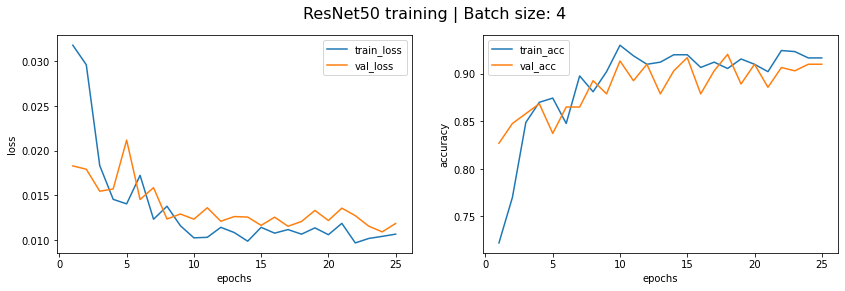


Training results:
	Min val loss 0.0109 was achieved during epoch #24
	Val accuracy during min val loss is 0.9100


In [21]:
model_resnet50 = models.resnet50(pretrained=True)
for param in model_resnet50.parameters():
    param.requires_grad = False
model_resnet50.fc = torch.nn.Linear(model_resnet50.fc.in_features, 2)
model_resnet50 = model_resnet50.to(DEVICE)

resnet50_training_results = training(model=model_resnet50,
                                      model_name='ResNet50',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet50, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet50_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet50",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  4%|▍         | 1/25 [00:45<18:21, 45.90s/it]

	| New lowest val loss for ResNet152: 0.019467355883245236
Epoch: 2 | Learning rate: [0.007]


  8%|▊         | 2/25 [01:30<17:22, 45.32s/it]

Epoch: 3 | Learning rate: [0.007]


 12%|█▏        | 3/25 [02:16<16:44, 45.65s/it]

	| New lowest val loss for ResNet152: 0.014101769788042484
Epoch: 4 | Learning rate: [0.00231]


 16%|█▌        | 4/25 [03:02<16:01, 45.81s/it]

	| New lowest val loss for ResNet152: 0.013618910807639257
Epoch: 5 | Learning rate: [0.00231]


 20%|██        | 5/25 [03:48<15:14, 45.75s/it]

Epoch: 6 | Learning rate: [0.00231]


 24%|██▍       | 6/25 [04:34<14:32, 45.91s/it]

	| New lowest val loss for ResNet152: 0.013432014849565433
Epoch: 7 | Learning rate: [0.0007623]


 28%|██▊       | 7/25 [05:20<13:44, 45.83s/it]

	| New lowest val loss for ResNet152: 0.01223708575778354
Epoch: 8 | Learning rate: [0.0007623]


 32%|███▏      | 8/25 [06:06<13:01, 45.94s/it]

Epoch: 9 | Learning rate: [0.0007623]


 36%|███▌      | 9/25 [06:52<12:12, 45.77s/it]

Epoch: 10 | Learning rate: [0.00025155900000000005]


 40%|████      | 10/25 [07:37<11:27, 45.82s/it]

	| New lowest val loss for ResNet152: 0.01168630078795872
Epoch: 11 | Learning rate: [0.00025155900000000005]


 44%|████▍     | 11/25 [08:23<10:40, 45.78s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 48%|████▊     | 12/25 [09:10<09:59, 46.11s/it]

	| New lowest val loss for ResNet152: 0.01068335310088722
Epoch: 13 | Learning rate: [8.301447000000002e-05]


 52%|█████▏    | 13/25 [09:55<09:10, 45.88s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 56%|█████▌    | 14/25 [10:41<08:23, 45.75s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 60%|██████    | 15/25 [11:27<07:37, 45.77s/it]

Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 64%|██████▍   | 16/25 [12:12<06:50, 45.58s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 68%|██████▊   | 17/25 [12:57<06:03, 45.49s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 72%|███████▏  | 18/25 [13:43<05:18, 45.51s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 76%|███████▌  | 19/25 [14:28<04:33, 45.57s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 80%|████████  | 20/25 [15:14<03:47, 45.56s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 84%|████████▍ | 21/25 [15:59<03:01, 45.43s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 88%|████████▊ | 22/25 [16:44<02:16, 45.43s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 92%|█████████▏| 23/25 [17:29<01:30, 45.33s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 96%|█████████▌| 24/25 [18:15<00:45, 45.27s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


100%|██████████| 25/25 [19:01<00:00, 45.65s/it]

	| New lowest val loss for ResNet152: 0.00995014485448702
Training complete in 19m 1s


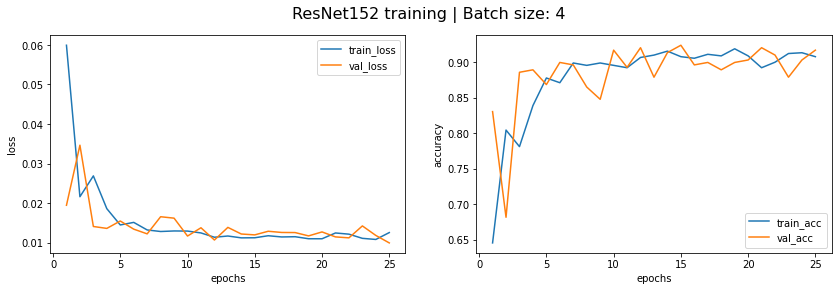


Training results:
	Min val loss 0.0100 was achieved during epoch #25
	Val accuracy during min val loss is 0.9170


In [22]:
model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 2)
model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet152",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  4%|▍         | 1/25 [00:46<18:27, 46.14s/it]

	| New lowest val loss for VGG16: 0.01812739009005388
Epoch: 2 | Learning rate: [0.007]


  8%|▊         | 2/25 [01:30<17:12, 44.87s/it]

Epoch: 3 | Learning rate: [0.007]


 12%|█▏        | 3/25 [02:15<16:31, 45.05s/it]

	| New lowest val loss for VGG16: 0.01668508397254152
Epoch: 4 | Learning rate: [0.00231]


 16%|█▌        | 4/25 [03:01<15:55, 45.52s/it]

	| New lowest val loss for VGG16: 0.016100578557919052
Epoch: 5 | Learning rate: [0.00231]


 20%|██        | 5/25 [03:48<15:17, 45.86s/it]

	| New lowest val loss for VGG16: 0.011515536862763876
Epoch: 6 | Learning rate: [0.00231]


 24%|██▍       | 6/25 [04:33<14:30, 45.83s/it]

	| New lowest val loss for VGG16: 0.010311828637785668
Epoch: 7 | Learning rate: [0.0007623]


 28%|██▊       | 7/25 [05:19<13:44, 45.80s/it]

	| New lowest val loss for VGG16: 0.00752769368394539
Epoch: 8 | Learning rate: [0.0007623]


 32%|███▏      | 8/25 [06:03<12:46, 45.09s/it]

Epoch: 9 | Learning rate: [0.0007623]


 36%|███▌      | 9/25 [06:46<11:53, 44.62s/it]

Epoch: 10 | Learning rate: [0.00025155900000000005]


 40%|████      | 10/25 [07:32<11:15, 45.03s/it]

	| New lowest val loss for VGG16: 0.006874131593066928
Epoch: 11 | Learning rate: [0.00025155900000000005]


 44%|████▍     | 11/25 [08:18<10:33, 45.22s/it]

	| New lowest val loss for VGG16: 0.005752967738233842
Epoch: 12 | Learning rate: [0.00025155900000000005]


 48%|████▊     | 12/25 [09:02<09:42, 44.81s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 52%|█████▏    | 13/25 [09:45<08:52, 44.37s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 56%|█████▌    | 14/25 [10:28<08:04, 44.07s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 60%|██████    | 15/25 [11:12<07:18, 43.86s/it]

Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 64%|██████▍   | 16/25 [11:57<06:39, 44.38s/it]

	| New lowest val loss for VGG16: 0.005136751621368641
Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 68%|██████▊   | 17/25 [12:41<05:52, 44.09s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 72%|███████▏  | 18/25 [13:24<05:07, 43.86s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 76%|███████▌  | 19/25 [14:08<04:22, 43.74s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 80%|████████  | 20/25 [14:51<03:38, 43.67s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 84%|████████▍ | 21/25 [15:34<02:54, 43.52s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 88%|████████▊ | 22/25 [16:17<02:10, 43.38s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 92%|█████████▏| 23/25 [17:01<01:26, 43.42s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 96%|█████████▌| 24/25 [17:44<00:43, 43.38s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


100%|██████████| 25/25 [18:28<00:00, 44.33s/it]


Training complete in 18m 28s


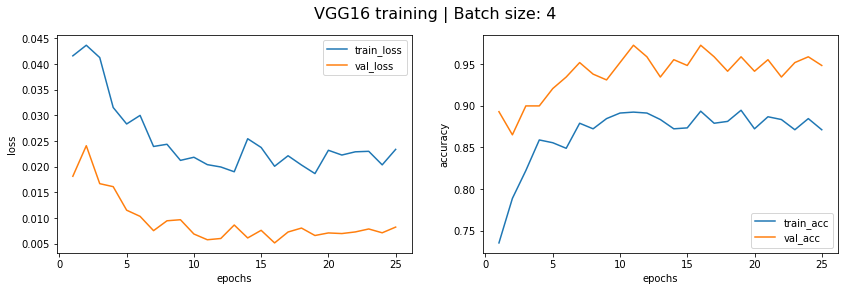


Training results:
	Min val loss 0.0051 was achieved during epoch #16
	Val accuracy during min val loss is 0.9723


In [23]:
model_vgg16 = models.vgg16(pretrained=True)
for param in model_vgg16.parameters():
    param.requires_grad = False
model_vgg16.classifier[6] = torch.nn.Linear(in_features=model_vgg16.classifier[6].in_features, out_features=2)
model_vgg16 = model_vgg16.to(DEVICE)

vgg16_training_results = training(model=model_vgg16,
                                     model_name='VGG16',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg16, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg16_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG16",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  4%|▍         | 1/25 [00:47<19:01, 47.54s/it]

	| New lowest val loss for VGG19_bn: 0.029256977856313895
Epoch: 2 | Learning rate: [0.007]


  8%|▊         | 2/25 [01:35<18:24, 48.02s/it]

	| New lowest val loss for VGG19_bn: 0.02356133777583759
Epoch: 3 | Learning rate: [0.007]


 12%|█▏        | 3/25 [02:23<17:36, 48.01s/it]

	| New lowest val loss for VGG19_bn: 0.018521124477720592
Epoch: 4 | Learning rate: [0.00231]


 16%|█▌        | 4/25 [03:12<16:52, 48.23s/it]

	| New lowest val loss for VGG19_bn: 0.015684875843331062
Epoch: 5 | Learning rate: [0.00231]


 20%|██        | 5/25 [04:00<16:01, 48.10s/it]

	| New lowest val loss for VGG19_bn: 0.014239682909423505
Epoch: 6 | Learning rate: [0.00231]


 24%|██▍       | 6/25 [04:48<15:12, 48.04s/it]

	| New lowest val loss for VGG19_bn: 0.013790849493139756
Epoch: 7 | Learning rate: [0.0007623]


 28%|██▊       | 7/25 [05:36<14:25, 48.08s/it]

	| New lowest val loss for VGG19_bn: 0.011787352342300349
Epoch: 8 | Learning rate: [0.0007623]


 32%|███▏      | 8/25 [06:24<13:37, 48.12s/it]

	| New lowest val loss for VGG19_bn: 0.011334670262868841
Epoch: 9 | Learning rate: [0.0007623]


 36%|███▌      | 9/25 [07:12<12:49, 48.07s/it]

	| New lowest val loss for VGG19_bn: 0.010195604709192957
Epoch: 10 | Learning rate: [0.00025155900000000005]


 40%|████      | 10/25 [07:57<11:48, 47.23s/it]

Epoch: 11 | Learning rate: [0.00025155900000000005]


 44%|████▍     | 11/25 [08:43<10:53, 46.68s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 48%|████▊     | 12/25 [09:30<10:10, 46.94s/it]

	| New lowest val loss for VGG19_bn: 0.01012497977917582
Epoch: 13 | Learning rate: [8.301447000000002e-05]


 52%|█████▏    | 13/25 [10:18<09:26, 47.18s/it]

	| New lowest val loss for VGG19_bn: 0.009188713589650949
Epoch: 14 | Learning rate: [8.301447000000002e-05]


 56%|█████▌    | 14/25 [11:06<08:42, 47.48s/it]

	| New lowest val loss for VGG19_bn: 0.008769284856463798
Epoch: 15 | Learning rate: [8.301447000000002e-05]


 60%|██████    | 15/25 [11:52<07:49, 46.91s/it]

Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 64%|██████▍   | 16/25 [12:37<06:57, 46.43s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 68%|██████▊   | 17/25 [13:22<06:08, 46.01s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 72%|███████▏  | 18/25 [14:07<05:19, 45.67s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 76%|███████▌  | 19/25 [14:52<04:32, 45.46s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 80%|████████  | 20/25 [15:37<03:47, 45.42s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 84%|████████▍ | 21/25 [16:22<03:01, 45.28s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 88%|████████▊ | 22/25 [17:08<02:15, 45.26s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 92%|█████████▏| 23/25 [17:52<01:30, 45.09s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 96%|█████████▌| 24/25 [18:37<00:44, 44.99s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


100%|██████████| 25/25 [19:25<00:00, 46.60s/it]

	| New lowest val loss for VGG19_bn: 0.008356073142954222
Training complete in 19m 25s


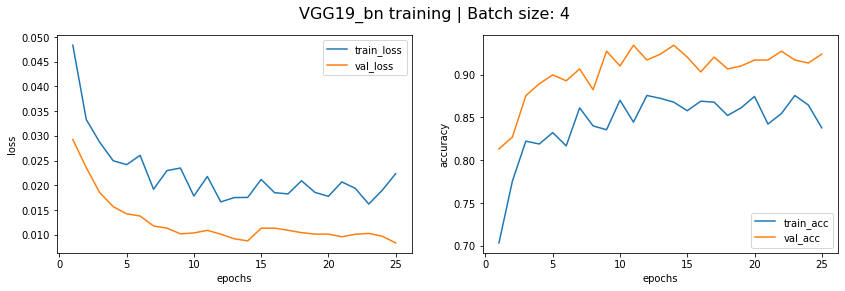


Training results:
	Min val loss 0.0084 was achieved during epoch #25
	Val accuracy during min val loss is 0.9239


In [24]:
model_vgg19_bn = models.vgg19_bn(pretrained=True)
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=2)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG19_bn",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [25]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC, modelD, modelE):
        super(EnsembleModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.modelD = modelD
        self.modelE = modelE

        #remove last linear layer
        # self.modelA.fc = nn.Identity()
        # self.modelB.fc = nn.Identity()
        # self.modelC.fc = nn.Identity()
        # self.modelD.fc = nn.Identity()
        # self.modelE.fc = nn.Identity()

        # create new classifier
        self.classifier = nn.Linear(2*5, 2)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x3 = self.modelC(x)
        x3 = x3.view(x3.size(0), -1)
        x4 = self.modelD(x)
        x4 = x4.view(x4.size(0), -1)
        x5 = self.modelE(x)
        x5 = x5.view(x4.size(0), -1)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_densenet161, model_resnet50, model_resnet152, model_vgg16, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  4%|▍         | 1/25 [01:19<31:37, 79.06s/it]

	| New lowest val loss for Ensemble: 0.005621843381581834
Epoch: 2 | Learning rate: [0.007]


  8%|▊         | 2/25 [02:38<30:29, 79.56s/it]

	| New lowest val loss for Ensemble: 0.004719096867554534
Epoch: 3 | Learning rate: [0.007]


 12%|█▏        | 3/25 [03:51<28:03, 76.50s/it]

Epoch: 4 | Learning rate: [0.00231]


 16%|█▌        | 4/25 [05:10<27:04, 77.38s/it]

	| New lowest val loss for Ensemble: 0.004493236815666451
Epoch: 5 | Learning rate: [0.00231]


 20%|██        | 5/25 [06:23<25:18, 75.94s/it]

Epoch: 6 | Learning rate: [0.00231]


 24%|██▍       | 6/25 [07:43<24:25, 77.14s/it]

	| New lowest val loss for Ensemble: 0.004104555516816341
Epoch: 7 | Learning rate: [0.0007623]


 28%|██▊       | 7/25 [08:56<22:42, 75.69s/it]

Epoch: 8 | Learning rate: [0.0007623]


 32%|███▏      | 8/25 [10:09<21:12, 74.88s/it]

Epoch: 9 | Learning rate: [0.0007623]


 36%|███▌      | 9/25 [11:22<19:48, 74.27s/it]

Epoch: 10 | Learning rate: [0.00025155900000000005]


 40%|████      | 10/25 [12:34<18:27, 73.81s/it]

Epoch: 11 | Learning rate: [0.00025155900000000005]


 44%|████▍     | 11/25 [13:48<17:10, 73.60s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 48%|████▊     | 12/25 [15:01<15:55, 73.52s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 52%|█████▏    | 13/25 [16:14<14:40, 73.36s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 56%|█████▌    | 14/25 [17:28<13:27, 73.45s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 60%|██████    | 15/25 [18:41<12:14, 73.47s/it]

Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 64%|██████▍   | 16/25 [19:54<11:00, 73.41s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 68%|██████▊   | 17/25 [21:08<09:48, 73.53s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 72%|███████▏  | 18/25 [22:21<08:33, 73.38s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 76%|███████▌  | 19/25 [23:34<07:19, 73.21s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 80%|████████  | 20/25 [24:56<06:19, 75.97s/it]

	| New lowest val loss for Ensemble: 0.004097749105296952
Epoch: 21 | Learning rate: [9.040275783000003e-06]


 84%|████████▍ | 21/25 [26:11<05:02, 75.67s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 88%|████████▊ | 22/25 [27:25<03:44, 74.99s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 92%|█████████▏| 23/25 [28:38<02:28, 74.42s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 96%|█████████▌| 24/25 [29:51<01:14, 74.01s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


100%|██████████| 25/25 [31:04<00:00, 74.58s/it]


Training complete in 31m 5s


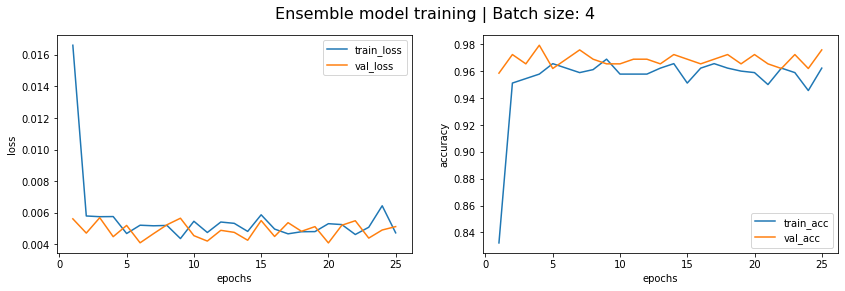


Training results:
	Min val loss 0.0041 was achieved during iteration #20
	Val accuracy during min val loss is 0.9723


In [26]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=25,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=25,
                           model_name="Ensemble model",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [210]:
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_preds_decoded = encoder_labels.inverse_transform(all_preds)


100%|██████████| 25/25 [00:07<00:00,  3.55it/s]


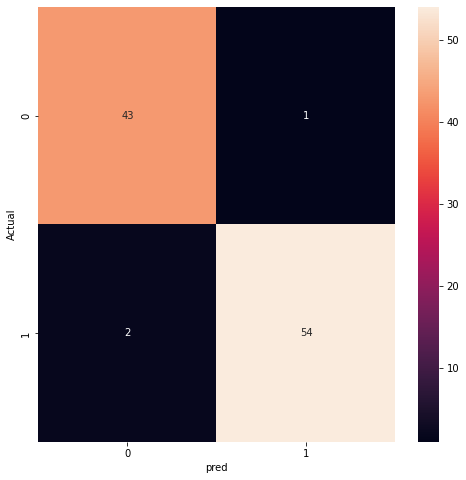

In [211]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test, all_preds_decoded)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [212]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test, all_preds_decoded,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.96      0.98      0.97        44
    Violation       0.98      0.96      0.97        56

     accuracy                           0.97       100
    macro avg       0.97      0.97      0.97       100
 weighted avg       0.97      0.97      0.97       100



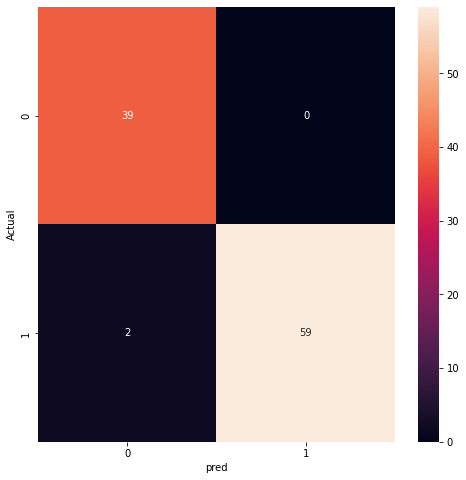

In [125]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test, all_preds_decoded)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [126]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test, all_preds_decoded,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.95      1.00      0.97        39
    Violation       1.00      0.97      0.98        61

     accuracy                           0.98       100
    macro avg       0.98      0.98      0.98       100
 weighted avg       0.98      0.98      0.98       100



In [ ]:
print("Our model: \n\n", ensemble_model, '\n')
print("The state dict keys: \n\n", ensemble_model.state_dict().keys())

In [137]:
model_save_name = 'ensembleclassifier3.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(ensemble_model.state_dict(), path)

In [138]:
model_save_name = 'ensembleclassifier3.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
ensemble_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
ensemble_model.eval()

In [ ]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# upload external file before import
from google.colab import files
files.upload()
import helper

files.upload()
import fc_model

In [ ]:
torch.save(ensemble_model.state_dict(), 'checkpoint.pth')

# download checkpoint file
# ensemble_model.download('checkpoint.pth')

In [142]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['modelA.features.conv0.weight', 'modelA.features.norm0.weight', 'modelA.features.norm0.bias', 'modelA.features.norm0.running_mean', 'modelA.features.norm0.running_var', 'modelA.features.norm0.num_batches_tracked', 'modelA.features.denseblock1.denselayer1.norm1.weight', 'modelA.features.denseblock1.denselayer1.norm1.bias', 'modelA.features.denseblock1.denselayer1.norm1.running_mean', 'modelA.features.denseblock1.denselayer1.norm1.running_var', 'modelA.features.denseblock1.denselayer1.norm1.num_batches_tracked', 'modelA.features.denseblock1.denselayer1.conv1.weight', 'modelA.features.denseblock1.denselayer1.norm2.weight', 'modelA.features.denseblock1.denselayer1.norm2.bias', 'modelA.features.denseblock1.denselayer1.norm2.running_mean', 'modelA.features.denseblock1.denselayer1.norm2.running_var', 'modelA.features.denseblock1.denselayer1.norm2.num_batches_tracked', 'modelA.features.denseblock1.denselayer1.conv2.weight', 'modelA.features.denseblock1.denselayer2.norm1.weight', 'm

In [144]:
ensemble_model.load_state_dict(state_dict)

<All keys matched successfully>

test on other data

In [213]:
test2_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing')
test3_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Benchmark_validation') 

In [214]:


# List of files for testing
files_test2 = []
labels_test2 = []
for label in labels:
  for filename in os.listdir(test2_dir + '/' + label):
      files_test2.append(test2_dir + '/' + label + '/' + filename)
      files_test2 = sorted(files_test2)
      labels_test2.append(label)

files_test3 = []
labels_test3 = []
for label in labels:
  for filename in os.listdir(test3_dir + '/' + label):
      files_test3.append(test3_dir + '/' + label + '/' + filename)
      files_test3 = sorted(files_test3)
      labels_test3.append(label)

In [215]:
print("\nThe first five files from the list of test images:", files_test2[:5])
print("\nThe first five labels from the list of test labels:", labels_test2[:5])
print("\nThe first five files from the list of test images:", files_test3[:5])
print("\nThe first five labels from the list of test labels:", labels_test3[:5])


The first five files from the list of test images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_2532090.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_2857314.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_4326839.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_6340112.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _2_1274240.jpg']

The first five labels from the list of test labels: ['Non_violation', 'Non_violation', 'Non_violation', 'Non_violation', 'Non_violation']

The first five files from the list of test images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Benchmark_validation/Non_violation/IMG_1736.JPG', '/content/gdrive/MyDrive/GTVD

In [229]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

In [230]:
test_dataset2 = ImagesDataset(files=files_test2,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')
test_dataset3 = ImagesDataset(files=files_test3,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')

In [225]:
# train_dataset = ImagesDataset(files=files_test2,
#                               labels=labels_test2,
#                               encoder=encoder_labels,
#                               transforms=transforms_train,
#                               mode='train')
# train_dataset = ImagesDataset(files=files_test3,
#                               labels=labels_test3,
#                               encoder=encoder_labels,
#                               transforms=transforms_train,
#                               mode='train')

In [232]:
print(len(test_dataset2),len(test_dataset3))

48 142


In [233]:
test_dataloader2 = DataLoader(test_dataset2, batch_size=20, shuffle=False)
test_dataloader3 = DataLoader(test_dataset3, batch_size=20, shuffle=False)

In [223]:
test_dataset3[1]


In [234]:
all_preds2 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader2):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds2.extend(preds.tolist())

all_preds_decoded2 = encoder_labels.inverse_transform(all_preds2)


100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


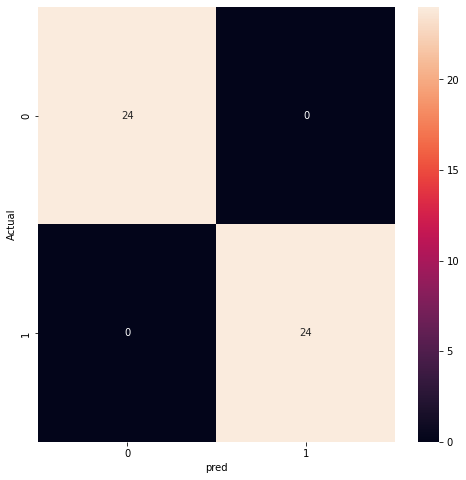

In [235]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test2, all_preds_decoded2)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [236]:
all_preds3 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader3):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds3.extend(preds.tolist())

all_preds_decoded3 = encoder_labels.inverse_transform(all_preds3)

100%|██████████| 8/8 [00:45<00:00,  5.69s/it]


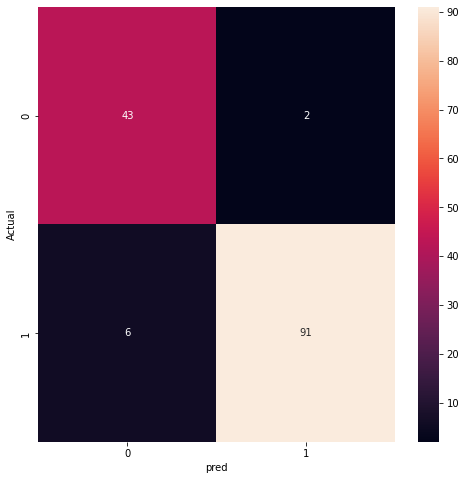

In [237]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test3, all_preds_decoded3)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [239]:
!ls 

checkpoint.pth		 gdrive			sample_data
DenseNet161_weights.pth  ResNet152_weights.pth	VGG16_weights.pth
Ensemble_weights.pth	 ResNet50_weights.pth	VGG19_bn_weights.pth


In [243]:
!jupyter nbconvert --to html /content/gdrive/MyDrive/Colab\ Notebooks/ensemble_MixedData_v1

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/Colab Notebooks/ensemble_MixedData_v1.ipynb to html
[NbConvertApp] Writing 2406954 bytes to /content/gdrive/MyDrive/Colab Notebooks/ensemble_MixedData_v1.html
